In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from keras.utils import plot_model
from keras.preprocessing import sequence, text
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

In [2]:
embedding_file = 'data/crawl-300d-2M.vec'

In [22]:
embeddings_index = {}
with open(embedding_file,encoding='utf8') as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [4]:
train = pd.read_csv('data/train.csv')
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
test = pd.read_csv('data/test.csv')
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [70]:
sub = pd.read_csv('data/sample_submission.csv')
sub.head()

CPU times: user 15 µs, sys: 24 µs, total: 39 µs
Wall time: 826 µs


In [8]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

test_labels = pd.read_csv('data/test_labels.csv')
y_te = test_labels[list_classes].values
y_te

array([[-1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1],
       ...,
       [-1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1]])

In [9]:
train["comment_text"].fillna("fillna")
test["comment_text"].fillna("fillna")
X_train = train["comment_text"].str.lower()
y_train = train[list_classes].values

X_test = test["comment_text"].str.lower()

In [23]:
max_features=100000 #vocab size
maxlen=200 #max comment length
embed_size=300

In [26]:
tok=text.Tokenizer(num_words=max_features,lower=True)
tok.fit_on_texts(list(X_train)+list(X_test))
X_train=tok.texts_to_sequences(X_train)
X_test=tok.texts_to_sequences(X_test)
x_train=sequence.pad_sequences(X_train,maxlen=maxlen)
x_test=sequence.pad_sequences(X_test,maxlen=maxlen)

NEED TO PARAMETER TEST THIS:

In [28]:
#training params
batch_size = 256 
num_epochs = 8 

#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4

In [30]:
word_index = tok.word_index
#prepare embedding matrix
num_words = min(max_features, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embed_size))
for word, i in word_index.items():
    if i >= max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [39]:
#CNN architecture
print("training CNN ...")
model = Sequential()
model.add(Embedding(max_features, embed_dim,
          weights=[embedding_matrix], input_length=maxlen, trainable=False))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(len(list_classes), activation='sigmoid'))  #multi-label (k-hot encoding)

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

training CNN ...
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 300)          30000000  
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 200, 64)           134464    
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 100, 64)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 100, 64)           28736     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 64)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 3

In [45]:
#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

In [46]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=num_epochs, callbacks=callbacks_list, validation_split=0.1, shuffle=True, verbose=2)
%time

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 7.87 µs
Train on 143613 samples, validate on 15958 samples
Epoch 1/8
 - 117s - loss: 0.0361 - accuracy: 0.9862 - val_loss: 0.0528 - val_accuracy: 0.9823
Epoch 2/8
 - 119s - loss: 0.0336 - accuracy: 0.9872 - val_loss: 0.0502 - val_accuracy: 0.9822
Epoch 3/8
 - 120s - loss: 0.0318 - accuracy: 0.9879 - val_loss: 0.0553 - val_accuracy: 0.9821
Epoch 4/8
 - 116s - loss: 0.0299 - accuracy: 0.9886 - val_loss: 0.0569 - val_accuracy: 0.9820
Epoch 5/8
 - 717s - loss: 0.0288 - accuracy: 0.9890 - val_loss: 0.0567 - val_accuracy: 0.9822
Epoch 6/8
 - 13657s - loss: 0.0275 - accuracy: 0.9895 - val_loss: 0.0580 - val_accuracy: 0.9818
Epoch 7/8
 - 18857s - loss: 0.0263 - accuracy: 0.9898 - val_loss: 0.0596 - val_accuracy: 0.9818
Epoch 8/8
 - 313s - loss: 0.0255 - accuracy: 0.9902 - val_loss: 0.0597 - val_accuracy: 0.9816


In [72]:
model.save('data/models/CNN_fasttext_model.h5')
# loading trained model
#model = load_model('data/models/bidir_gru_fasttext_model.h5')

In [73]:
print('Predicting....')
y_pred = model.predict(x_test,batch_size=1024,verbose=1)

Predicting....
153164/153164 [==============================] - 38s 250us/step


In [75]:
subid = pd.DataFrame({'id': sub["id"]})
submission = pd.concat([subid, pd.DataFrame(y_pred, columns = list_classes)], axis=1)
submission.to_csv('submission.csv', index=False)
#submission result: 0.96791

Twitter Data

In [76]:
twitter_df = pd.read_csv('data/sample_with_label.csv')
twitter_df.columns = ['Index','TweetID','ScreenName','TweetText','TweetDateTime','Followers','UserID','WasDeleted']
twitter_df.head()

,Index,TweetID,ScreenName,TweetText,TweetDateTime,Followers,UserID,WasDeleted
0,0,1244721273793646594,ShannePanne,b'Rhoa',2020-03-30 20:20:52,287,990004076829200385,0
1,1,1244721275232301058,25_ShadesOfK,b'@HisTemp_TAYtion Lol I learned from that shi...,2020-03-30 20:20:52,1189,624244930,0
2,2,1244721275936878593,PlagueJesterSky,b'Trying to set up the stream and I keep getti...,2020-03-30 20:20:52,415,755613447702847488,0
3,3,1244721278650650624,spitbull1963,b'@EricksonReal @Ilhan And you can test as muc...,2020-03-30 20:20:53,16,47425986,0
4,4,1244721278931664896,kamanfrancis,b'Me taking notes for the future when I\xe2\x8...,2020-03-30 20:20:53,1928,269295980,0


In [77]:
from keras.models import load_model

model = load_model('data/models/CNN_fasttext_model.h5')

In [78]:
test = twitter_df['TweetText'].str.lower()
test = tok.texts_to_sequences(test)
test = sequence.pad_sequences(test,maxlen=maxlen)

In [79]:
pred = model.predict(test,batch_size=1024,verbose=1)
df = pd.DataFrame(pred)
twitter_df['ToxicityProba'] = df[0]

twitter_df.head()

404148/404148 [==============================] - 108s 268us/step


,Index,TweetID,ScreenName,TweetText,TweetDateTime,Followers,UserID,WasDeleted,ToxicityProba
0,0,1244721273793646594,ShannePanne,b'Rhoa',2020-03-30 20:20:52,287,990004076829200385,0,0.531848
1,1,1244721275232301058,25_ShadesOfK,b'@HisTemp_TAYtion Lol I learned from that shi...,2020-03-30 20:20:52,1189,624244930,0,0.977713
2,2,1244721275936878593,PlagueJesterSky,b'Trying to set up the stream and I keep getti...,2020-03-30 20:20:52,415,755613447702847488,0,0.590908
3,3,1244721278650650624,spitbull1963,b'@EricksonReal @Ilhan And you can test as muc...,2020-03-30 20:20:53,16,47425986,0,0.957538
4,4,1244721278931664896,kamanfrancis,b'Me taking notes for the future when I\xe2\x8...,2020-03-30 20:20:53,1928,269295980,0,0.012910


In [80]:
twitter_df = twitter_df.sort_values(by=['ToxicityProba'],ascending=False)
twitter_df.head(10)

,Index,TweetID,ScreenName,TweetText,TweetDateTime,Followers,UserID,WasDeleted,ToxicityProba
283045,283045,1245391795116220417,Stuey3_,b'@chriscane30 Shut up you fucking stupid cunt...,2020-04-01 16:45:16,103,1171932518859313156,0,0.999967
164472,164472,1245280194144768005,fernvndooo_,b'@senor_lechuga fuck you bitch I fell from my...,2020-04-01 09:21:49,628,2944411927,0,0.999931
60909,60909,1245170906588160001,HOJlNS,b'FUCK YOU FUCK YOU FUCK YOU FUCK YOU U DUMB B...,2020-04-01 02:07:32,176,1234221635076530176,0,0.999931
238689,238689,1245360191828303872,PLAYER_BRUNO_BB,b'@YayaToure Fuck you bitch you are no pro pla...,2020-04-01 14:39:42,1,923151105487458304,0,0.999926
211457,211457,1245337437343113222,spityeji,b'@halogenhvm fuck bitch pussy ass motherfucki...,2020-04-01 13:09:16,41,1201342096537346048,0,0.999926
265829,265829,1245379850619117570,Maxbarrera35,"b'@JLozanoA Fuck off, fucking asshole cocksuck...",2020-04-01 15:57:49,55,1213023079909056513,0,0.999926
178881,178881,1245299989313617920,FistingFans,b'@sarah_wide Can you fuck your ass with a bot...,2020-04-01 10:40:28,14625,130925646,0,0.999925
121303,121303,1245227720675602434,Corduroyalism,b'@cboddy2727 @AHume92 Shut your fucking worth...,2020-04-01 05:53:18,391,991461063035162624,0,0.999924
17601,17601,1244733161248116736,ZyFi_,b'fuck you Kefla. Fuck you bitch #PS4share\n\n...,2020-03-30 21:08:06,97,1148424969623392256,0,0.999923
27959,27959,1244739228648574976,yugiohmachinim2,b'fuck you fuck you fuck you im being gangstal...,2020-03-30 21:32:12,327,1158069001957851136,0,0.999923


In [81]:
twitter_df.tail(10)

,Index,TweetID,ScreenName,TweetText,TweetDateTime,Followers,UserID,WasDeleted,ToxicityProba
352871,352871,1245438470027276288,meresheep,b'Animal Crossing Easter event: https://t.co/g...,2020-04-01 19:50:45,108,221155662,0,0.0
162389,162389,1245277212095332352,winwinverse,b'is this love talk animal crossing version ht...,2020-04-01 09:09:58,234,1215615309555462144,0,0.0
389284,389284,1245463309580750848,affinity4anime,b'@AustinJohnPlays NinWire updated a workaroun...,2020-04-01 21:29:27,419,1425483864,0,0.0
184820,184820,1245307609185308673,myo_ogie,b'@YGMMV1 animal crossing yang pocket camp buk...,2020-04-01 11:10:45,155,1177827926017888256,1,0.0
274510,274510,1245385818119831552,Ceatras,b'dan already finished animal crossing... i \x...,2020-04-01 16:21:31,65,908536260,0,0.0
22827,22827,1244736150981533707,softlyhstyles,b'@5SOS favorite villager on animal crossing??...,2020-03-30 21:19:59,455,954797904,0,0.0
151237,151237,1245262971468570625,kokokrunchyi,b'@davidarhentio animal crossing pocket camp k...,2020-04-01 08:13:22,181,2977086546,0,0.0
109707,109707,1245215332324835329,ZEFGame_ru,b'\xd0\x92 Animal Crossing: New Horizons \xd1\...,2020-04-01 05:04:04,623,843764451983740928,0,0.0
86591,86591,1245193560808280065,soulbitsx,b'EGGS!!! EASTER ANIMAL CROSSING IS HAPPENING!...,2020-04-01 03:37:34,116,1068002136116494338,0,0.0
381992,381992,1245458314894376961,petrichorlauren,b'I might be having an animal crossing date \x...,2020-04-01 21:09:36,766,3165699024,0,0.0


In [82]:
def is_response_tweet(tweet):
    return '@' in tweet

In [83]:
twitter_df['IsResponseTweet'] = twitter_df['TweetText'].apply(is_response_tweet)
response_tweets_df = twitter_df[twitter_df['IsResponseTweet']]

In [84]:
response_tweets_df.head(50)['WasDeleted'].values.sum()/50

0.1

In [85]:
response_tweets_df.tail(50)['WasDeleted'].values.sum()/50

0.08

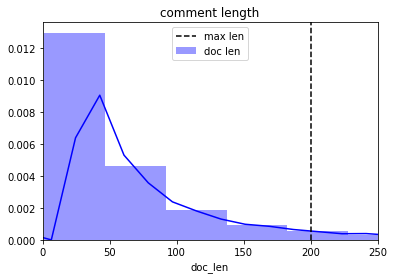

In [20]:
train['doc_len'] = train['comment_text'].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(train['doc_len'].mean() + train['doc_len'].std()).astype(int)
sns.distplot(train['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=200, color='k', linestyle='--', label='max len')
plt.xlim(0,250)
plt.title('comment length'); plt.legend()
plt.show()

In [16]:
twitter_df = pd.read_csv('data/sample_with_label.csv')

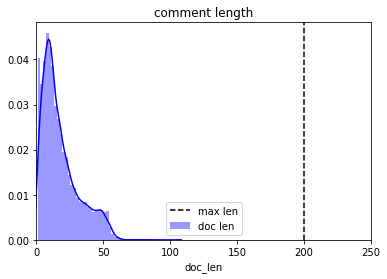

In [21]:
twitter_df['doc_len'] = twitter_df['TweetText'].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(twitter_df['doc_len'].mean() + twitter_df['doc_len'].std()).astype(int)
sns.distplot(twitter_df['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=200, color='k', linestyle='--', label='max len')
plt.xlim(0,250)
plt.title('comment length'); plt.legend()
plt.show()